<a href="https://colab.research.google.com/github/HIsu1231/Hands-On-ML/blob/main/Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#인구조사 데이터를 사용하여 구역의 중간 주택 가격을 예측해보자

##1. 큰 그림 보기

###1. 문제 정의

1. 레이블 된 훈련 샘플(각 샘플에 구역의 중간 주택 가격을 포함됨) -> 지도학습 작업

2. 값을 예측 해야 함 -> 회귀 문제

3. 예측에 필요한 특성이 여러 개(구역의 인구, 중간 소득 등) -> 다중 회귀 문제

4. 각 구역마다 하나의 값을 예측 -> 단변량 회귀 (구역마다 여러 값을 예측 -> 다변량 회귀)

5. 데이터에 연속적 흐름 X. 빠르게 변하는 데이터에 적응하지 않아도 되고 데이터가 메모리에 들어갈 만큼 충분히 작음 -> 일반적인 배치 학습

###2. 성능 측정 지표 선택

RMSE와 MAE 모두 예측값의 벡터와 타깃값의 벡터 사이의 거리를 재는 방법.

회귀 문제의 전형적 성능 지표 -> **평균 제곱근 오차(RMSE; root mean square error)**


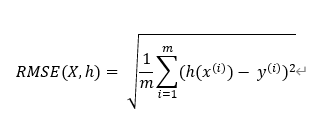

회귀 문제에서 이상치로 보이는 구역이 많다면 -> **평균 절대 오차(mean absolute error)**

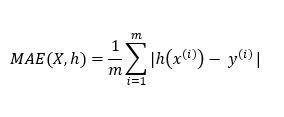



((선형대수학에서 놈은 벡터의 크기(magnitude) 또는 길이(length)를 측정하는 방법을 의미))

##2. 설정 및 데이터 가져오기

In [14]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

os.chdir('./drive/MyDrive/hands_on')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("그림 저장: ", fig_id)
  
  if tight_layout:
      plt.tight_layout()
  
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [16]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path = HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path) #zip 파일 모든 파일과 폴더를 현재 작업 디렉터리로 압축 해제
  housing_tgz.close()

In [17]:
fetch_housing_data()

In [15]:
os.getcwd()

'/content/drive/MyDrive/hands_on'

In [18]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [19]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [31]:
housing.info()

#total_bedrooms에 207개의 구역은 null 값 -> 전처리 필요
#ocean_proximity는 텍스트 타입 
#    -> 처음 다섯 행을 출력했을 때 열의 값이 반복되는 것으로 보아 범주형으로 예상

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [22]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [33]:
housing.describe() #숫자형 특성의 요약 정보 보여줌

#count, mean, min, max: 널 값이 제외되어 나타남
#std: 값이 퍼져 있는 정도 측정.(표준편차)
#25%, 50%, 75%: 백분위수

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장:  attribute_histogram_plots


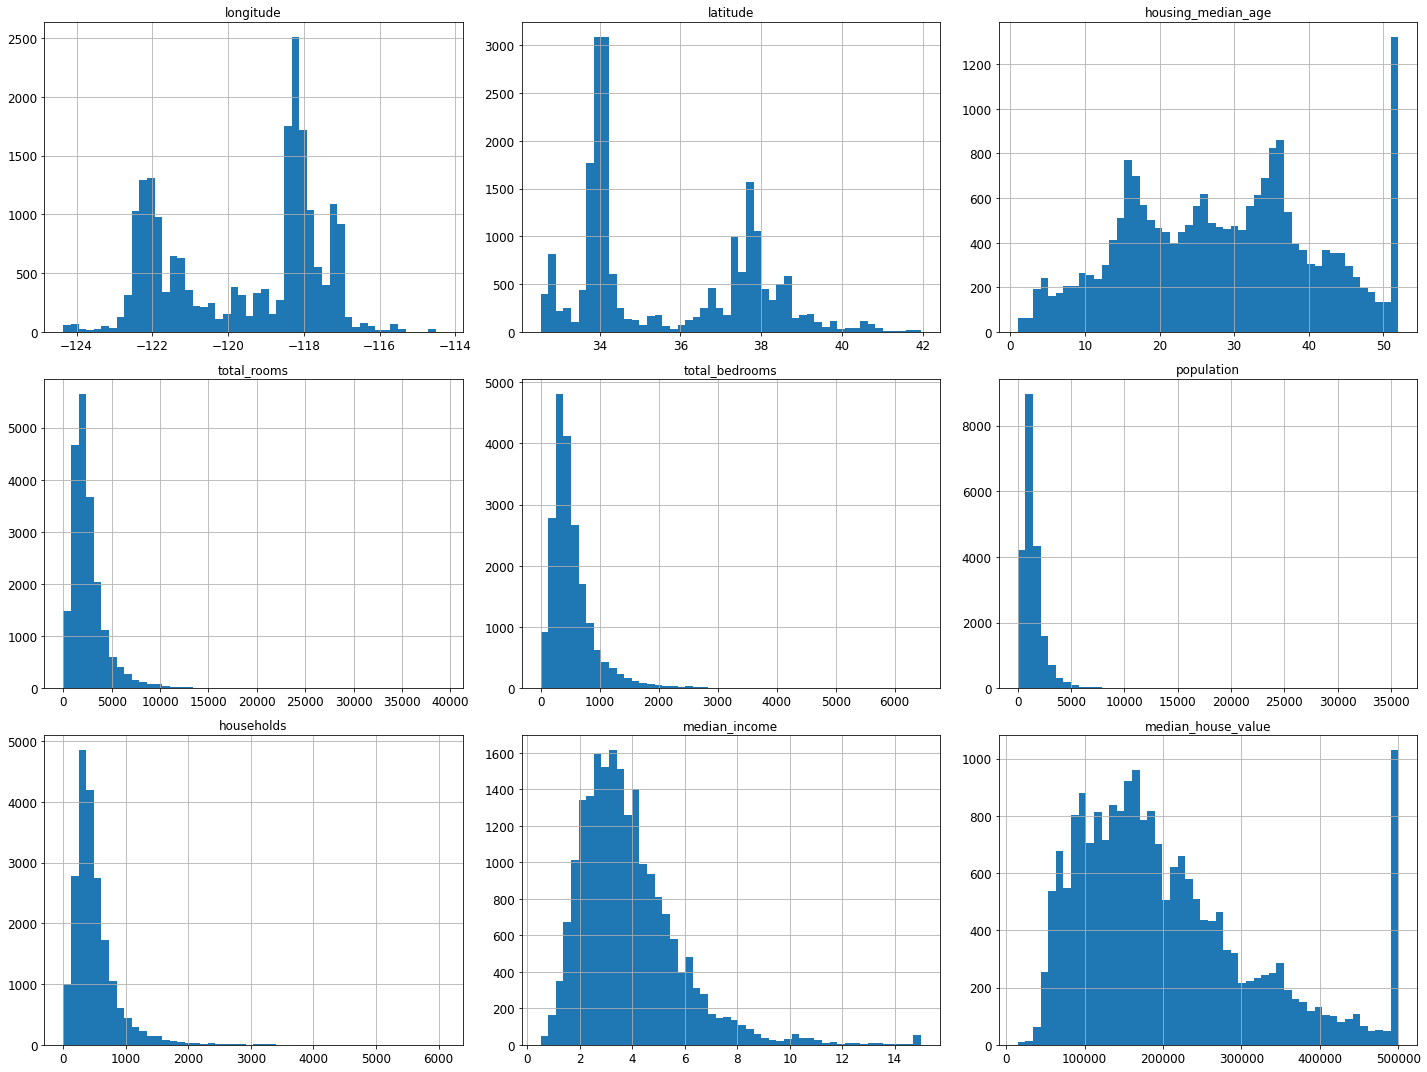

In [35]:
 #히스토그램
 #주어진 값의 범위(수평축)에 속한 샘플 수 (수직축)을 나타냄

 housing.hist(bins=50, figsize=(20,15))
 save_fig("attribute_histogram_plots")
 plt.show()


 

데이터 스누핑(data snooping) 편향
-> 이해가 잘 안가네....

In [36]:
np.random.seed(42)

In [40]:
#테스트 세트 만들기

import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) #무작위로 섞인 배열 생성
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    print(shuffled_indices)
    return data.iloc[train_indices], data.iloc[test_indices]

In [41]:
train_set, test_set = split_train_test(housing, 0.2)

[20512 15568  4047 ... 17789 18814 16770]


In [42]:
print(len(train_set))
print(len(test_set))

16512
4128


In [59]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  print(ids)
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  print(in_test_set)
  return data.loc[~in_test_set], data.loc[in_test_set]

In [60]:
housing_with_id = housing.reset_index()

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

0            0
1            1
2            2
3            3
4            4
         ...  
20635    20635
20636    20636
20637    20637
20638    20638
20639    20639
Name: index, Length: 20640, dtype: int64
0        False
1        False
2         True
3        False
4        False
         ...  
20635    False
20636    False
20637    False
20638    False
20639    False
Name: index, Length: 20640, dtype: bool


In [62]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [64]:
# 고유 식별자는 안전한 특성을 사용해야함
# 위도와 경도는 몇백 년 후까지 안정적이라고 보장할 수 있으므로 두 값을 연결하여 ID 생성

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

0       -122192.12
1       -122182.14
2       -122202.15
3       -122212.15
4       -122212.15
           ...    
20635   -121050.52
20636   -121170.51
20637   -121180.57
20638   -121280.57
20639   -121200.63
Name: id, Length: 20640, dtype: float64
0        False
1        False
2        False
3        False
4        False
         ...  
20635    False
20636    False
20637    False
20638    False
20639    False
Name: id, Length: 20640, dtype: bool


In [65]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [66]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [67]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


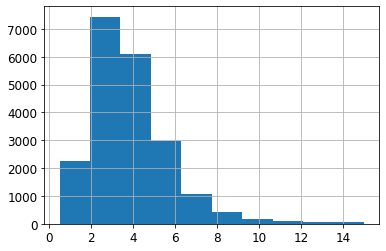

In [74]:
housing["median_income"].hist()

**<계층적 샘플링(stratified sampling)>**

인구 1000명에게 질문을 하려 할 때, 전체 인구 중 1000명을 뽑아야 함. 전체 인구는 계층이라는 동질의 그룹으로 나뉘고, 테스트 세트가 전체 인구를 대표하도록 각 계층에서 올바른 수의 샘플을 추출해야함.

In [99]:
#중간소득이 중간 주택 가격을 예측하는데 매우 중요하다고 가정하면
#중간 소득 대부분이 1.5와 6 사이에 모여 있지만 일부는 6을 넘기도한다. 
#계층별로 데이터셋에 충분한 샘플수가 있어야한다.
#즉, 너무 많은 계층으로 나누면 안되고 각 계층이 충분히 커야 한다는 뜻


#pd.cut()을 이용해 카테고리 5개를 가진 소득 카테고리 특성 만들기

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])


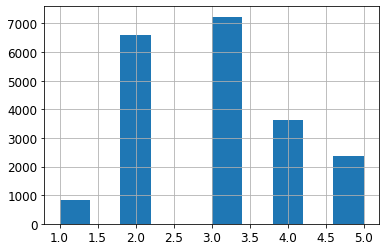

In [100]:
housing["income_cat"].hist()

In [101]:
#소득 카테고리 기반으로 계층 샘플링 시작

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [102]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [103]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [104]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({"Overall": income_cat_proportions(housing),
                              "Stratified": income_cat_proportions(strat_test_set),
                              "Random": income_cat_proportions(test_set),
                              }).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [105]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [106]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. 데이터 이해를 위한 탐색과 시각화

In [107]:
housing = strat_train_set.copy()

###지리적 데이터 시각화

그림 저장:  bad_visualization_plot


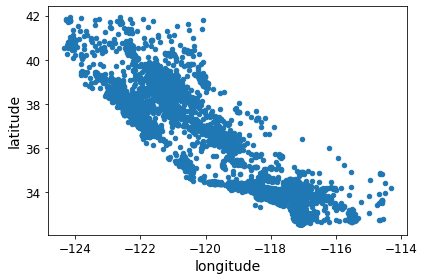

In [111]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

# 어떤 특별한 패턴을 찾기 힘듦

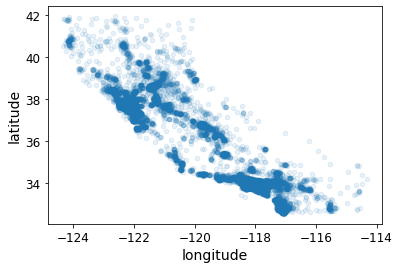

In [113]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

#alpha 옵션을 0.1로 주면 데이터 포인트가 밀집된 영역을 잘 보여줌

그림 저장:  housing_prices_scatterplot


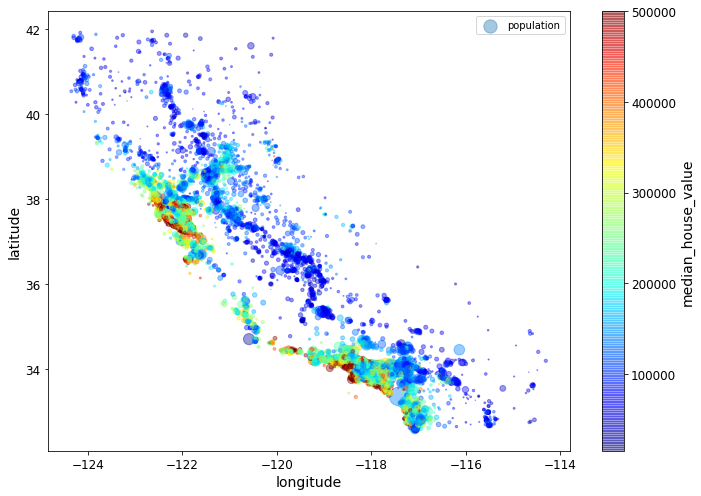

In [114]:
# 원의 반지름: 구역의 인구(매개변수 s)
# 색상: 주택 가격(매개변수 c)
# jet: 컬러맵 중 파란색(낮은 가격)에서 발간색(높은 가격)까지 범위를 가짐 (매개변수 cmap)

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", figsize=(10,7),
             c = "median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

plt.legend()
save_fig("housing_prices_scatterplot")